## Assignment-09

#### 1.思考在自然语言处理中如何发掘模型的可解释性

即使一个模型在交叉验证中得到了很高的分数，在真实预测中也不能完全相信它的结果，因为模型可能会利用一些不相关数据训练从而导致过拟合。在NLP中可用LIME发掘模型的可解释性。

LIME的主要思想是利用可解释性模型（如线性模型，决策树）局部近似目标黑盒模型的预测，此方法不深入模型内部，通过对输入进行轻微的扰动，探测黑盒模型的输出发生何种变化，根据这种变化在兴趣点（原始输入）训练一个可解释性模型。

为了做到与模型无关，lime不会深入模型内部。为了搞清楚哪一部分输入对预测结果产生贡献，将输入值在其周围做微小的扰动(比如去掉某些词)，观察模型的预测行为。然后根据这些扰动的数据点距离原始数据的距离分配权重，基于它们学习得到一个可解释的模型和预测结果。

#### 2.在Seq2Seq和注意力机制中如何可视化模型细节

将各时刻隐状态进行可视化，找出各神经元所捕获的特征，用在注意力机制中即可找出哪个词在seq2seq中更重要。

#### 3.对抗样本能否运用到自然语言处理模型中

使用对抗样本生成和防御的自然语言处理研究可以基本概括为以下三种：1. 用未察觉的扰动迷惑模型，并评价模型在这种情况下的表现；2. 有意的改变深度神经网络的输出；3. 检测深度神经网络是否过于敏感或过于稳定，并寻找防御攻击的方法。 NLP 模型需要对可辨识的特征鲁棒，而不像视觉只需要对「不太重要」的特征鲁棒。通过移除、添加或调序单词内部的字符，以构建更稳健的文本分类模型。这些增减或调序都是一种扰动，就像人类也很可能出现这些笔误一样。通过这些扰动，模型能学会如何处理错别字，从而不至于对分类结果产生影响。

#### 4.复现Kaggle心脏病数据集冠军kernel，理解所用的模型可解释性技巧

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [7]:
dt = pd.read_csv("heart.csv")

In [8]:
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [9]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [10]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [11]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [12]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [13]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [14]:
dt = pd.get_dummies(dt, drop_first=True)

In [15]:
dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [17]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [19]:
#code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [WinError 2] 系统找不到指定的文件。

In [20]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [21]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[29,  6],
       [ 4, 22]], dtype=int64)

In [22]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8787878787878788
Specificity :  0.7857142857142857


In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [25]:
auc(fpr, tpr)

0.9076923076923078

In [26]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0197 ± 0.0382,thalassemia_fixed defect
0.0197 ± 0.0131,max_heart_rate_achieved
0.0164 ± 0.0415,exercise_induced_angina_yes
0.0164 ± 0.0000,chest_pain_type_non-anginal pain
0.0131 ± 0.0245,thalassemia_reversable defect
0.0098 ± 0.0161,cholesterol
0.0098 ± 0.0161,st_depression
0.0066 ± 0.0445,num_major_vessels
0.0066 ± 0.0161,chest_pain_type_atypical angina
0.0033 ± 0.0245,st_slope_upsloping


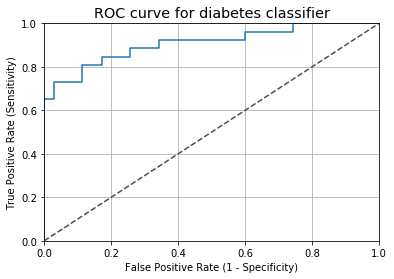

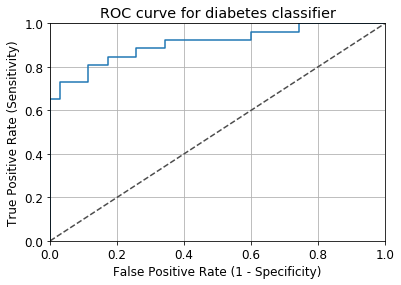

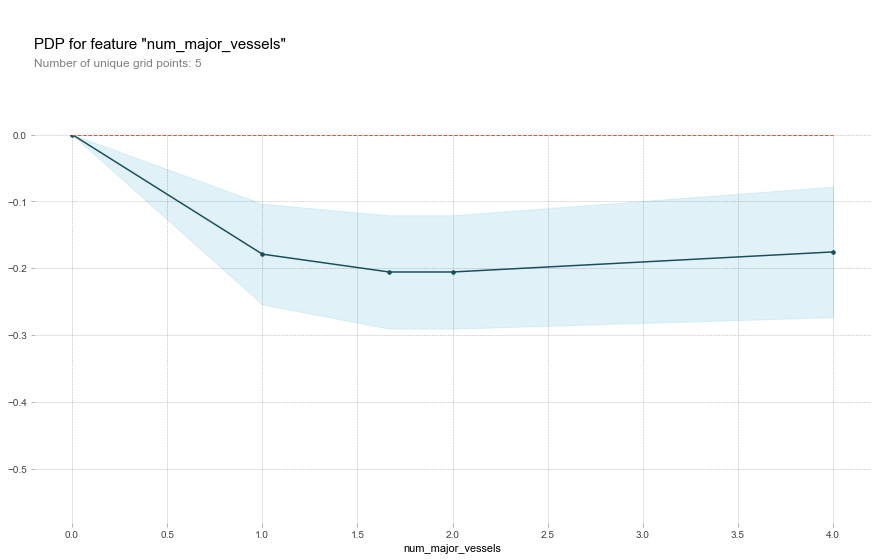

In [27]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

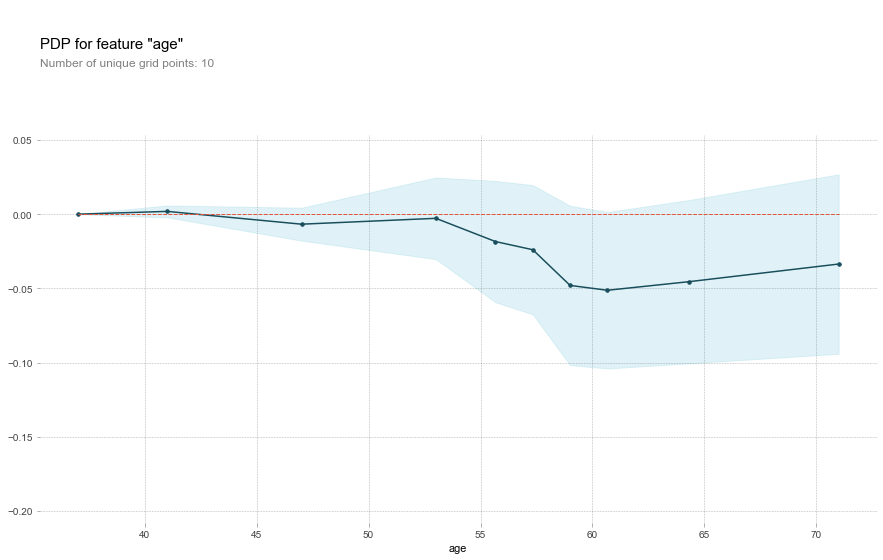

In [28]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

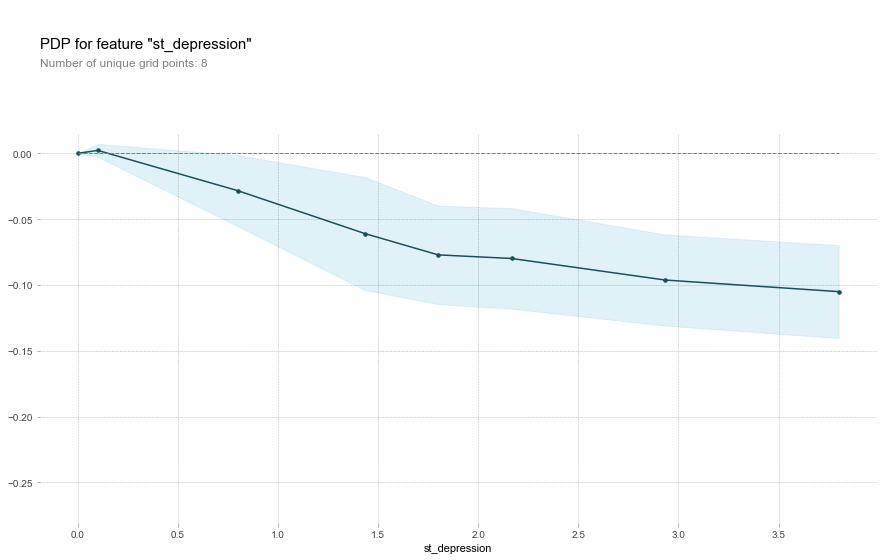

In [29]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [38]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

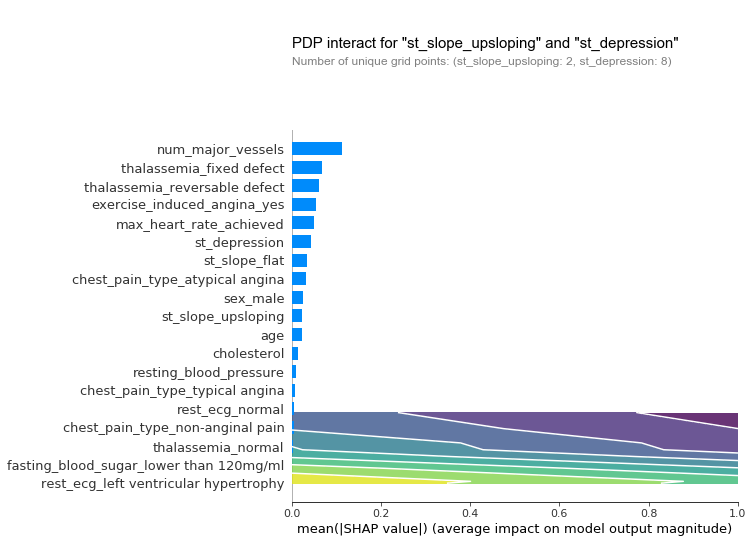

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

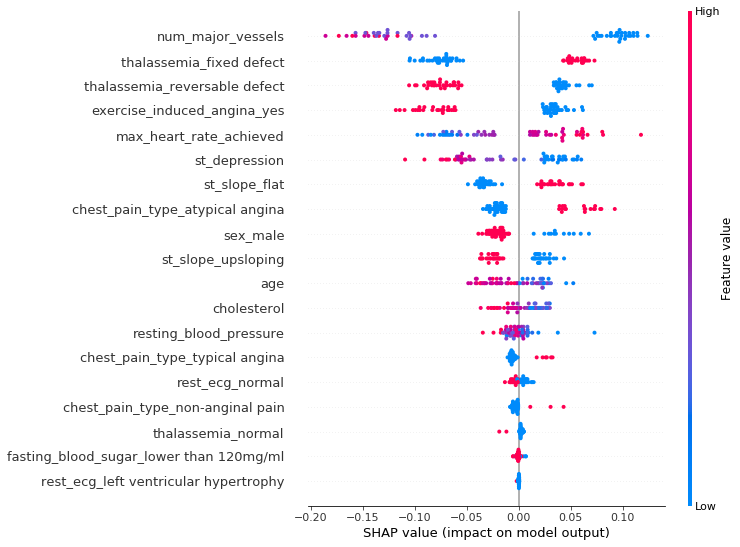

In [32]:
shap.summary_plot(shap_values[1], X_test)

In [33]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [34]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

In [35]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

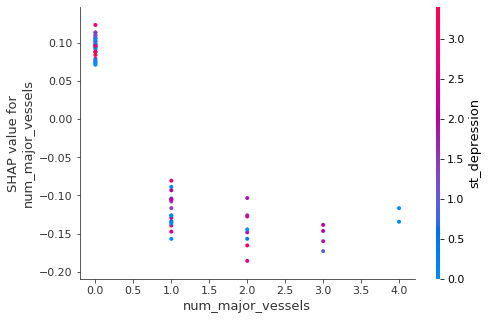

In [36]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

In [37]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])